In [253]:
import os
import glob
import json
from tld import get_fld
import seaborn as sns
import pandas as pd

In [254]:
# Constants
DATA_DIR = '../crawl_data'
SRC_DIR = '../crawler_src'

In [255]:
# Load the datasets
os.chdir(DATA_DIR)

# Get desktop json files
data_json_desktop = glob.glob('*_desktop.json')

# Get mobile json files
data_json_mobile = glob.glob('*_mobile.json')

In [256]:
def init_data_object():
    return  {
        # Per url data
        'tranco_ranks': [],
        'page_load_times': [],
        'num_requests': [],
        'distinct_third_parties': [],
        'num_distinct_tracker_domains': [],
        'num_distinct_tracker_entities': [],
        
        # Global data
        'failures': {
            'timeout_failures': 0,
            'TLS_failures': 0,
            'consent_failures': 0
        },
        'third_party_counts': {},
        'third_party_tracker_counts': {},
        'third_party_tracker_entities': {},
        'uber_cookie': {
            'request_hostname': '',
            'website': '',
            'num_cookies': 0,
            'first_party': False
        },
        'longest_lifespan_cookies': [],
        'canvas_fingerprints': [],
        'tracker_redirect_combos': []
    }

In [257]:
def parse_stupid_blocklist_to_something_readable(file_path):
    url_list = {}
    
    with open(file_path, encoding='utf-8') as blocklist_file:
        blocklist = json.load(blocklist_file)
        
        for cat, entities in blocklist['categories'].items():
            for entity_list in entities:
                for entity, url_objects in entity_list.items():
                    for url, aliases in url_objects.items():
                        all_urls = [url]
                        all_urls += aliases
                        
                        if entity not in url_list:
                            url_list[entity] = []
                            
                        for u in all_urls:
                            
                            try:
                                url_list[entity].append(get_fld(u, fix_protocol=True))
                            except:
                                pass
                        
                        url_list[entity] = list(set(url_list[entity]))
    
    return url_list

In [258]:
def create_stats_object(json_files):
    data_object = init_data_object()
    
    for json_file in json_files:
        with open(json_file, 'r', encoding='utf-8') as data_file:
            data = json.load(data_file)
            
            # Append tranco rank
            data_object['tranco_ranks'].append(data['rank'])
            
            # Updata failure counts
            if data['failure_status']['timeout']:
                data_object['failures']['timeout_failures'] += 1
            if data['failure_status']['TLS'] != 'null':
                data_object['failures']['TLS_failures'] += 1
            if data['failure_status']['consent']:
                data_object['failures']['consent_failures'] += 1
                
            # Only proceed if there is no timeout
            if data['failure_status']['timeout']:
                data['num_requests'].append(None)
                data['distinct_third_parties'].append(None)
                data['num_distinct_tracker_domains'].append(None)
                data['num_distinct_tracker_entities'].append(None)
                continue
            
            # Append page load time
            data_object['page_load_times'].append(data['load_time'])
            
            # Append number of requests
            data_object['num_requests'].append(len(data['requests']))
            
            # Append distinct third parties
            distinct_third_parties = set([ get_fld(d['request_url'], fix_protocol=True)
                                           for d in data['requests']
                                         ])
            distinct_third_parties.remove(get_fld(data['website_domain'], fix_protocol=True))
            data_object['distinct_third_parties'].append(len(distinct_third_parties))
            
            # Append number of distinct tracker domains
            tracker_dict = parse_stupid_blocklist_to_something_readable(SRC_DIR + '/disconnectmeblocklist.json')
            distinct_tracker_domains = []
            for third_party_domain in distinct_third_parties:
                for _, domains in tracker_dict.items():
                    if third_party_domain in domains:
                        distinct_tracker_domains.append(third_party_domain)
            data_object['num_distinct_tracker_domains'].append(len(distinct_tracker_domains))
            
            # Append number of distinct tracker entities/companies
            distinct_tracker_entities = []
            with open(SRC_DIR + '/domain_map.json', encoding='utf-8') as domain_map_json_file:
                domain_map_json = json.load(domain_map_json_file)
                
                for third_tracker_domain in distinct_tracker_domains:
                    if third_tracker_domain in domain_map_json.keys():
                        distinct_tracker_entities.append(domain_map_json[third_tracker_domain]['entityName'])
                    else:
                        print('DOMAIN NOT FOUND IN ENTITY LIST, IMPLEMENT THIS WHEN YOU SEE THIS! DOMAIN OF DOOM: {}'
                              .format(third_party_domain))
                
            distinct_tracker_entities = set(distinct_tracker_entities)
            data_object['num_distinct_tracker_entities'].append(len(distinct_tracker_entities))
            
            # Update third party reference counts
            for party in distinct_third_parties:
                if party in data_object['third_party_counts']:
                    data_object['third_party_counts'][party] += 1
                else:
                    data_object['third_party_counts'][party] = 1
            
            # Update third party tracker counts
            for tracker in distinct_tracker_domains:
                if tracker in data_object['third_party_tracker_counts']:
                    data_object['third_party_tracker_counts'][tracker] += 1
                else:
                    data_object['third_party_tracker_counts'][tracker] =1
            
            # Update third party tracker entities
            for entity in distinct_tracker_entities:
                if entity in data_object['third_party_tracker_entities']:
                    data_object['third_party_tracker_entities'][entity] += 1
                else:
                    data_object['third_party_tracker_entities'][entity] =1
                    
            # Update the uber cookie
            max_cookie_count = None
            request_url = None
            for request in data['requests']:
                if 'cookie' not in request['request_headers']:
                    continue
                    
                cookie_count = len(request['request_headers']['cookie'].split(';'))
                if max_cookie_count is None or cookie_count > max_cookie_count:
                    max_cookie_count = cookie_count
                    request_url = request['request_url']
            
            if max_cookie_count is not None and \
               max_cookie_count > data_object['uber_cookie']['num_cookies']:
                data_object['uber_cookie']['num_cookies'] = max_cookie_count
                data_object['uber_cookie']['request_hostname'] = get_fld(request_url, fix_protocol=True)
                data_object['uber_cookie']['website'] = data['website_domain']
                data_object['uber_cookie']['first_party'] = data_object['uber_cookie']['request_hostname'] == \
                                                            data_object['uber_cookie']['website']
                
            # Get longest lasting cookies
            cookie_ids = []
            for request in data['requests']:
                if 'cookie' not in request['request_headers']:
                    continue
                    
                cookies = request['request_headers']['cookie'].split(';')
                for cookie in cookies:
                    cookie_ids.append(cookie.split('=')[0])
            
            all_cookies = []
            for cookie in data['cookies']:
                if cookie['name'] in cookie_ids:
                    cookie_data = cookie.copy()
                    cookie_data['size'] = len(cookie_data['value'])
                    
                    if 'sameSite' not in cookie_data:
                        cookie_data['sameSite'] = None
                        
                    all_cookies.append(cookie_data)
            
            sort_alg = lambda c: c['expiry']
            all_cookies.sort(key=sort_alg, reverse=True)
            data_object['longest_lifespan_cookies'] += all_cookies[:3]
            data_object['longest_lifespan_cookies'].sort(key=sort_alg, reverse=True)
            data_object['longest_lifespan_cookies'] = data_object['longest_lifespan_cookies'][:3]
            
            # HTTP redirect pairs for tracker domains
            tracker_redirect_combos = []
            for request in data['requests']:
                if request['response_status_code'] >= 300 and \
                   request['response_status_code'] <= 399 and \
                   'location' in request['response_headers']:
                    origin_domain = get_fld(request['request_url'], fix_protocol=True)
                    redirect_domain = get_fld(request['response_headers']['location'], fix_protocol=True)
                    if origin_domain != redirect_domain and \
                       (origin_domain in distinct_tracker_domains or \
                        redirect_domain in distinct_tracker_domains):
                        tracker_redirect_combos.append((origin_domain, redirect_domain))
            data_object['tracker_redirect_combos'] = list(set(tracker_redirect_combos))
            
            # Fingerprints
            for fingerprint in data['canvas_image_data']:
                fingerprint['website'] = get_fld(data['website_domain'], fix_protocol=True)
            data_object['canvas_fingerprints'] += data['canvas_image_data']
            
    return data_object

In [259]:
# Create the data objects
desktop_data = create_stats_object(data_json_desktop)
mobile_data = create_stats_object(data_json_mobile)

KeyError: 'response_status_code'

In [260]:
def get_url_df(crawl_data):
    slice_keys = ['tranco_ranks', 'page_load_times', 'num_requests', 'distinct_third_parties',
              'num_distinct_tracker_domains', 'num_distinct_tracker_entities']
    df_input = {k: v for k, v in crawl_data.items() if k in slice_keys}
    return pd.DataFrame(data=df_input)

df_desktop = get_url_df(desktop_data)
df_mobile = get_url_df(mobile_data)

df_desktop

,tranco_ranks,page_load_times,num_requests,distinct_third_parties,num_distinct_tracker_domains,num_distinct_tracker_entities
0,None,5,26,3,3,1


<AxesSubplot:>

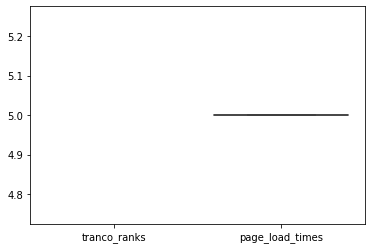

In [261]:
sns.boxplot(data=pd.DataFrame(data=df_desktop, columns=['tranco_ranks','page_load_times']))


In [262]:
#12
canvas_data = []
for crawl_data in []:
    pass

In [263]:
#1
desktop_failures = {'Page load timeout': desktop_data['failures']['timeout_failures'],
                    'TLS error': desktop_data['failures']['TLS_failures'],
                    'Consent click error': desktop_data['failures']['consent_failures']}

mobile_failures = {'Page load timeout': mobile_data['failures']['timeout_failures'],
                    'TLS error': mobile_data['failures']['TLS_failures'],
                    'Consent click error': mobile_data['failures']['consent_failures']}

failures_table = pd.DataFrame({'Crawl-desktop': desktop_failures, 'Crawl-mobile': mobile_failures})
failures_table.columns.name = 'Error type'
print(failures_table)

Error type           Crawl-desktop  Crawl-mobile
Page load timeout                0             0
TLS error                        1             1
Consent click error              1             0


In [264]:
#4,5,6
def ten_most_prev_websites_table(desktop_counts, mobile_counts):
    table_desktop = pd.DataFrame({'Third-party desktop': desktop_counts.keys(), 'Nr of websites desktop': desktop_counts.values()}).sort_values('Nr of websites desktop').reset_index(drop=True)
    table_mobile = pd.DataFrame({'Third-party mobile': mobile_counts.keys(), 'Nr of websites mobile': mobile_counts.values()}).sort_values('Nr of websites mobile').reset_index(drop=True)

    table = pd.concat([table_desktop, table_mobile],axis=1)

    # Some settings to make the table prettier
    pd.set_option('precision', 0) # No decimals in count
    table.fillna("",inplace=True) # Replace 'None'  with ''
    table.index += 1 # Start at index 1
    columns=[('Crawl-desktop','Third-party'),('Crawl-desktop','Number of websites'),('Crawl-mobile','Third-party'),('Crawl-mobile','Number of websites') ]
    table.columns=pd.MultiIndex.from_tuples(columns) # Add nested column names

    #Only print the first 10 rows
    return table.head(10)

print(ten_most_prev_websites_table(desktop_data['third_party_counts'], mobile_data['third_party_counts']), "\n") #4
print(ten_most_prev_websites_table(desktop_data['third_party_tracker_counts'], mobile_data['third_party_tracker_counts']), "\n") #5
print(ten_most_prev_websites_table(desktop_data['third_party_tracker_entities'], mobile_data['third_party_tracker_entities'])) #6

  Crawl-desktop                    Crawl-mobile                   
    Third-party Number of websites  Third-party Number of websites
1   youtube.com                  1  gstatic.com                  1
2     google.nl                  1                                
3   gstatic.com                  1                                 

  Crawl-desktop                    Crawl-mobile                   
    Third-party Number of websites  Third-party Number of websites
1   youtube.com                  1  gstatic.com                  1
2     google.nl                  1                                
3   gstatic.com                  1                                 

  Crawl-desktop                    Crawl-mobile                   
    Third-party Number of websites  Third-party Number of websites
1    Google LLC                  1   Google LLC                  1


In [23]:
#12
canvas_data = []
for crawl_data in []:
    pass